# Adaptive Style Transfer

In [1]:
%pylab inline

from PIL import Image
import os
import sys
import time
from datetime import datetime

import numpy as np
from collections import namedtuple
import torch
import torch as t
from torchvision import models
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from IPython import display
from natsort import natsorted
from pdb import set_trace as bp
from pathlib import Path
import shutil

Populating the interactive namespace from numpy and matplotlib


In [2]:
DEVICE=torch.device('cuda:0')
torch.cuda.set_device(DEVICE)

In [3]:
MAX_PIXELS_COUNT = 1500**2
MIN_VGG_SIDE = 80

In [4]:
image2tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.unsqueeze(0)),  # batch of 1 image
])

def ensure_rgb_mode(img):
    '''Used in get_or_create_object_instance for creating contents, styles'''
    if img.mode != 'RGB':  # if image is grayscale
        img = img.convert('RGB')
    return img

def scale_img(img, scale=1, max_pixels_count=MAX_PIXELS_COUNT, min_side=MIN_VGG_SIDE):
    '''Resize PIL image to make sure it fits into GPU memory (max_pixels_count). Used in task_processor.'''

    W, H = img.width, img.height

    max_scale = sqrt(max_pixels_count / (W * H)) # ensure pixels_count<=max_pixels_count after scaling
    min_scale = max(min_side / W, min_side / H) # ensure  height>=MIN_IMAGE_LENGTH, width>=MIN_IMAGE_LENGTH after scaling

    # are constraints compatible? they are checked when image is loaded, so should satisfy this.
    assert min_scale <= max_scale, f"Input image has too stretched dimensions: {width}x{height}. Try cropping it to decrease aspect ratio."
    scale = min(scale, max_scale)
    scale = max(scale, min_scale)
    if scale==1:
        print(f'Original image scale {H}x{W} left.')
        return img
    else:
        print(f'Image rescaled to {int(H*scale)}x{int(W*scale)}.')
        return img.resize([int(W*scale), int(H*scale)], Image.ANTIALIAS)    
    

def ensure_rgb(img):
    if img.mode != 'RGB':  # if image is grayscale
        img = img.convert('RGB')
    return img  


def prepare_img(img):
    '''Used in get_or_create_object_instance for creating contents, styles'''
    img = scale_img(img)
    ensure_rgb(img)
    return img  

In [5]:
def filename2stylename(filename):
    i = filename.find('-')
    if i==-1:
        return filename[:filename.rfind('.')]
    else:
        return filename[:i]

In [6]:
def plot_img(img, figsize=[20,10]):
    figure(figsize=figsize);
    xticks(None);
    axis('off');
    imshow(img); 

In [7]:
content_img = Image.open('../../Images/Contents/1.jpg')
style_img = Image.open('../../Images/Styles/style1.jpg')

content_img = scale_img(content_img, max_pixels_count=1000**2)
style_img = scale_img(style_img, max_pixels_count=1000**2)

Image rescaled to 817x1223.
Original image scale 900x720 left.


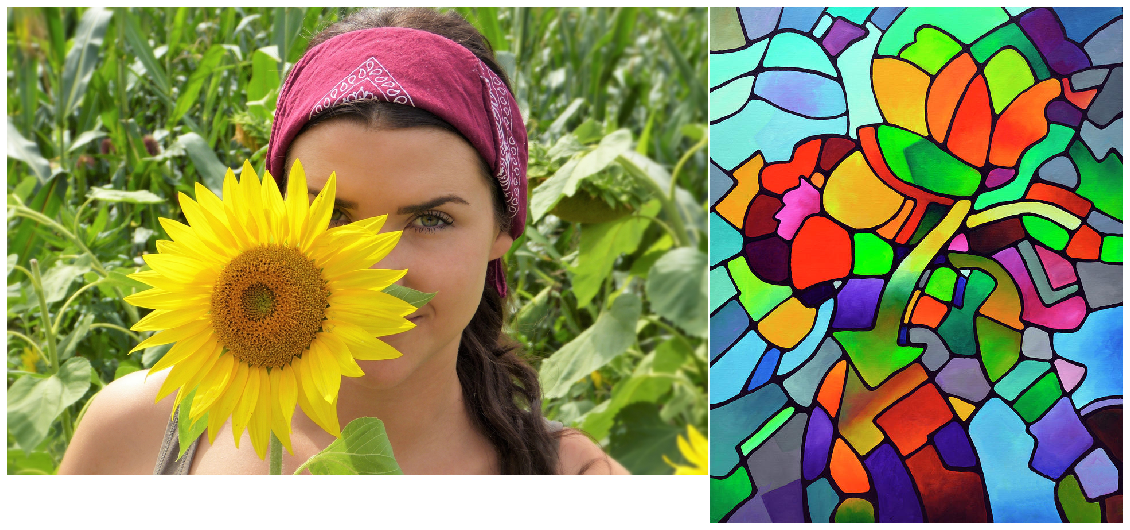

In [8]:
border=3
demo_img = Image.new('RGBA', (content_img.width + border + style_img.width,
                             max([content_img.height, style_img.height])), 'white')
demo_img.paste(content_img)
demo_img.paste(style_img, (content_img.width + border, 0))
plot_img(demo_img)

# utils.py

In [9]:
def postprocess_image(data):
    img = (255*data).cpu().squeeze(0).numpy()  # data in [0,1] (output of sigmoid)
    img = img.transpose(1, 2, 0).astype("uint8")  # CxHxW -> HxWxC for PIL image
    img = Image.fromarray(img)
    return img


def normalize_batch(batch):
    # normalize using imagenet mean and std
    mean = batch.new_tensor([0.485, 0.456, 0.406]).view(-1, 1, 1) # new_tensor for same dimension of tensor
    std = batch.new_tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
    return (batch - mean) / std


def gram_matrix(y):
    (b, ch, h, w) = y.size()
    features = y.view(b, ch, w * h)
    features_t = features.transpose(1, 2) # swapped ch and w*h, transpose share storage with original
    gram = features.bmm(features_t) / (ch * h * w)
    return gram

# vgg.py

In [10]:
# borrowed from https://github.com/pytorch/examples/blob/master/fast_neural_style/neural_style/vgg.py

class Vgg16(torch.nn.Module):
    def __init__(self, requires_grad=False):
        super(Vgg16, self).__init__()
        vgg_pretrained_features = models.vgg16(pretrained=True).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        for x in range(4):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(4, 9):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(9, 16):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(16, 23):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, X):
        h = self.slice1(X)
        h_relu1_2 = h
        h = self.slice2(h)
        h_relu2_2 = h
        h = self.slice3(h)
        h_relu3_3 = h
        h = self.slice4(h)
        h_relu4_3 = h
        vgg_outputs = namedtuple("VggOutputs", ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3'])
        out = vgg_outputs(h_relu1_2, h_relu2_2, h_relu3_3, h_relu4_3) 
        return out


In [11]:
content2tensor_eval = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.to(DEVICE)),
    transforms.Lambda(lambda x: x.unsqueeze(0)),  # batch of 1 image
])

# Modular transformer

In [12]:
class ConvLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ConvLayer, self).__init__()
        reflection_padding = kernel_size // 2  # same dimension after padding
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)  # remember this dimension

    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out


class UpsampleConvLayer(torch.nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride, upsample):
        super(UpsampleConvLayer, self).__init__()
        self.upsample = upsample
        self.upsample_layer = torch.nn.Upsample(mode='bilinear', align_corners=True, scale_factor=upsample)  # rem: mode='nearest'
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x_in):
        x_in = self.upsample_layer(x_in)
        out = self.reflection_pad(x_in)
        out = self.conv2d(out)
        return out


class ResidualBlock(torch.nn.Module):
    """ResidualBlock
    introduced in: https://arxiv.org/abs/1512.03385
    recommended architecture: http://torch.ch/blog/2016/02/04/resnets.html
    """

    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in1 = torch.nn.InstanceNorm2d(channels, affine=True)
        self.conv2 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in2 = torch.nn.InstanceNorm2d(channels, affine=True)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.relu(self.in1(self.conv1(x)))
        out = self.in2(self.conv2(out))
        out = out + residual  # need relu right after
        return out

In [21]:
from torch.nn.utils.parametrizations import orthogonal

# Teleport

class PatternBankTransform(torch.nn.Module):
    def __init__(self, size, num_patterns):
        super().__init__()
        
        self.P = torch.nn.ModuleList()
        
        for i in range(num_patterns):
            self.P.append(orthogonal(torch.nn.Linear(size, size, bias=False)))
            self.P[i].weight = torch.eye(size)
            
    def forward(self, x, p):
        b, c, w, h = x.shape
        x_r = x.reshape(b, c, w*h)
        
        x_mean = x_r.mean(-1).unsqueeze(-1)
        
        x_r = (x_r - x_mean)
        x_r = x_r.transpose(1, 2)
        
        y = self.P[p](x_r)

        y = y.transpose(1, 2) + x_mean
        return y.reshape(b, c, w, h)
    
    
    def mixture(self, x, p, alpha):
        b, c, w, h = x.shape
        x_r = x.reshape(b, c, w*h)
        
        x_mean = x_r.mean(-1).unsqueeze(-1)
        x_std = x_r.std(-1).unsqueeze(-1)
        
        x_r = (x_r - x_mean)/x_std
        x_r = x_r.transpose(1, 2)
        
        #y = alpha[0]*self.P[p[0]](x_r) + alpha[1]*self.P[p[1]](x_r)+ alpha[2]*x_r
        y = alpha*self.P[p](x_r) + (1-alpha)*x_r

        y = y.transpose(1, 2) * x_std + x_mean
        return y.reshape(b, c, w, h)

class TransformerNet(torch.nn.Module):

    def __init__(self, num_patterns, DEVICE):
        super(TransformerNet, self).__init__()
        self.DEVICE = DEVICE
        #         torch.cuda.set_device(DEVICE)
        #         torch.cuda.get_device_name(DEVICE)
        
        self.conv1 = ConvLayer(3, 32, kernel_size=9, stride=1)
        self.scaler1 = Scaler(32 - 8, self.DEVICE)

        self.conv2 = ConvLayer(32, 64, kernel_size=3, stride=2)
        self.scaler2 = Scaler(64 - 16, self.DEVICE)

        self.conv3 = ConvLayer(64, 128, kernel_size=3, stride=2)
        self.scaler3 = Scaler(128 - 32, self.DEVICE)
        
        self.PBT1 = PatternBankTransform(128, num_patterns)
        
        self.res1 = ResidualBlock(128)
        self.res2 = ResidualBlock(128)
        self.res3 = ResidualBlock(128)
        
        self.PBT2 = PatternBankTransform(128, num_patterns)
        
        self.res4 = ResidualBlock(128)
        self.res5 = ResidualBlock(128)
        
        self.PBT3 = PatternBankTransform(128, num_patterns)

        self.deconv1 = UpsampleConvLayer(128, 64, kernel_size=3, stride=1, upsample=2)
        self.scaler4 = Scaler(64 - 16, self.DEVICE)
        self.deconv2 = UpsampleConvLayer(64, 32, kernel_size=3, stride=1, upsample=2)
        self.scaler5 = Scaler(32 - 8, self.DEVICE)
        
        self.deconv3 = ConvLayer(32, 3, kernel_size=9, stride=1)
        self.scaler6 = Scaler(3, self.DEVICE)
        self.relu = torch.nn.LeakyReLU()  # ReLU()
        self.sigmoid = torch.nn.Sigmoid()

        self.scalers = [self.scaler1, self.scaler2, self.scaler3, self.scaler4, self.scaler5, self.scaler6]
        self.to(self.DEVICE)

    def forward(self, X, style_names=None, pattern_num=None, alpha=None):  # style_names unspecified => works like autoencoder
        y = self.relu(self.scaler1(self.conv1(X), style_names))
        y = self.relu(self.scaler2(self.conv2(y), style_names))
        y = self.relu(self.scaler3(self.conv3(y), style_names))
        
        if (alpha is None):
            y = self.PBT1(y, pattern_num)
        else:
            y = self.PBT1.mixture(y, pattern_num, alpha)
        
        y = self.res1(y)
        y = self.res2(y)
        y = self.res3(y)
        
        if (alpha is None):
            y = self.PBT2(y, pattern_num)
        else:
            y = self.PBT2.mixture(y, pattern_num, alpha)
        
        y = self.res4(y)
        y = self.res5(y)
        
        if (alpha is None):
            y = self.PBT3(y, pattern_num)
        else:
            y = self.PBT3.mixture(y, pattern_num, alpha)
        
        y = self.relu(self.scaler4(self.deconv1(y), style_names))
        y = self.relu(self.scaler5(self.deconv2(y), style_names))
        y = self.sigmoid(self.scaler6(self.deconv3(y), style_names))
        return y
        
    def add_styles(self, style_names):
        '''add vanilla (uninitialized) styles'''
        for scaler in self.scalers:
            scaler.add_styles(style_names)

    def remove_styles(self, style_names):
        for scaler in self.scalers:
            scaler.remove_styles(style_names)

    def save_transformer(self, filename):
        '''Save transformer without scalers.'''
        transformer_params = dict((k, v) for k, v in self.state_dict().items() if not k.startswith('scaler'))
        torch.save(transformer_params, filename)
        print(f'Transformer (without scalers) saved to {filename}')

    def load_transformer(self, filename):
        '''Load transformer without scalers.'''
        state_dict = torch.load(filename)
        self.load_state_dict(state_dict)
        print(f'Transformer (without scalers) loaded from {filename}')

    def save_styles(self, styles_dir, style_names='all'):
        '''For each style_name from style_names save style representations stored in all scalers.
        Rating and extension of style image not saved, e.g. XXXX-23.jpg => XXXX.pth'''

        Path(styles_dir).mkdir(parents=True, exist_ok=True)
        if style_names == 'all':
            style_names = self.style_names
        for style_name in style_names:
            data = {f'scaler_{scaler_num}': scaler[style_name].state_dict() for scaler_num, scaler in enumerate(self.scalers, start=1)}
            torch.save(data, styles_dir + f'{style_name}.pth')

    def load_styles(self, styles_dir, style_names='all'):
        '''style name from filename: XXXX.jpg, XXXX.png XXXX-23.jpg XXXX-0.jpg => XXXX'''
        if style_names == 'all':
            style_filenames = [style_filename for style_filename in os.listdir(styles_dir) if style_filename.endswith('.pth')]
            style_names = [filename2stylename(style_filename) for style_filename in style_filenames]  # style_name = style_filename without extension
        else:
            style_filenames = [style_name + '.pth' for style_name in style_names]

        self.add_styles(style_names)

        print(f'Loading styles from folder: {styles_dir}')
        for style_name, style_filename in zip(style_names, style_filenames):
            data = torch.load(styles_dir + style_filename)
            for scaler_num, scaler in enumerate(self.scalers, start=1):
                scaler[style_name].load_state_dict(data[f'scaler_{scaler_num}'])

    def train_all(self):
        for p in self.parameters():
            p.requires_grad = True
        print('Training all parameters of transformer.')

    @property
    def style_names(self):
        return list(self.scaler1.keys())  # keys of all scalers are identical

    @property
    def styles_count(self):
        return len(self.style_names)

    def stylize(self, img, style_name, pixels_count=3000 ** 2, pattern_num = 0, alpha=None):

        print(f'Stylizing with style={style_name}...', end=' ')
        img = ensure_rgb_mode(img)
        img = scale_img(img, max_pixels_count=pixels_count)
        img = image2tensor(img)
        img = img.to(self.DEVICE)

        with torch.no_grad():
            output = self.forward(img, style_names=[style_name], pattern_num=pattern_num, alpha=alpha)

        print('Done!')
        return postprocess_image(output)
    
def set_PBT_mode(model, mode):
    if (mode=='unlock'):
        for p in model.parameters():
            p.requires_grad = True
            
        for p in model.PBT1.P.parameters():
            p.requires_grad = False
            
        for p in model.PBT2.P.parameters():
            p.requires_grad = False
    
        for p in model.PBT3.P.parameters():
            p.requires_grad = False

    if (mode=='lock'):
        for p in model.parameters():
            p.requires_grad = False
            
        for p in model.PBT1.P.parameters():
            p.requires_grad = True
            
        for p in model.PBT2.P.parameters():
            p.requires_grad = True
    
        for p in model.PBT3.P.parameters():
            p.requires_grad = True
    
class Scaler(torch.nn.Module):
    '''Mean and variance shift at particular layer, implementing transferring of style.'''

    def __init__(self, in_channels, DEVICE):
        super(Scaler, self).__init__()
        self.DEVICE = DEVICE
        self.in_channels = in_channels
        self.ains = torch.nn.ModuleDict()

    def forward(self, x, style_names=None):  # style_names unspecified => works like autoencoder
        if not style_names:
            return x
        else:  # x - batch_size x C x H x W, each batch element is processed with it's own style_id from style_ids
            # out0 = torch.cat([self.ains[style_name](x[num].unsqueeze(0)) for num, style_name in enumerate(style_names)], dim=0) # combine along batch dimension
            out = torch.cat([self.ains[style_name](x[num, :self.in_channels].unsqueeze(0)) for num, style_name in enumerate(style_names)], dim=0)  # combine along batch dimension
            out = torch.cat([out, x[:, self.in_channels:]], dim=1)  # combine rescaled and untouched channels
        return out

    def add_styles(self, style_names):
        for style_name in style_names:
            self.ains[style_name] = torch.nn.InstanceNorm2d(self.in_channels, affine=True)
            self.ains[style_name].to(self.DEVICE)

    def remove_styles(self, style_names):
        for style_name in style_names:
            del self.ains[style_name]

    def __getitem__(self, style_name):
        return self.ains[style_name]

    def keys(self):
        style_names = list(self.ains.keys())
        return style_names

# neural_style.py

In [14]:
sample_content_img = Image.open('../../Images/Contents/1.jpg')
sample_content_img = scale_img(sample_content_img, max_pixels_count = 500**2)
sample_content = content2tensor_eval(sample_content_img)

Image rescaled to 408x611.


In [15]:
def train(args):

    save_dir = args.models_dir+args.model_name+'/'
    shutil.rmtree(save_dir, ignore_errors=True)    
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    
    
    content2tensor_train = transforms.Compose([
        transforms.Resize(args.content_size), # the shorter side is resize to match image_size
        transforms.RandomCrop(args.content_size), 
        transforms.ToTensor(), # to tensor [0,1]
        transforms.Lambda(lambda x: x.to(DEVICE))
    ])    
    
    style2tesor_train = transforms.Compose([
        transforms.Resize(args.style_size),
        transforms.CenterCrop(args.style_size),
        transforms.ToTensor(),  # to tensor [0,1]
        transforms.Lambda(lambda x: x.to(DEVICE))
    ])
   
    fig = figure(figsize=[30,20])
    gs = fig.add_gridspec(4, 3)
    main_ax = fig.add_subplot(gs[0, :])
    axes=[]
    for i in range(3):
        for j in range(3):
            axes.append(fig.add_subplot(gs[1+i, j]))
    tight_layout()
    
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)

    train_dataset = datasets.ImageFolder(args.dataset, content2tensor_train)
    train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True) # to provide a batch loader

    style_filenames = os.listdir(args.style_images_dir)  # style_name=name of style file without extension
    style_names= [filename2stylename(filename) for filename in style_filenames]  # style name from filename: XXXX.jpg, XXXX.png XXXX-23.jpg XXXX-0.jpg => XXXX
    styles_count = len(style_names)
    print(f'Styles count: {styles_count}')

    transformer = TransformerNet(args.num_patterns, DEVICE)
    
    if args.init_transformer_model:
        transformer.load_transformer(args.init_transformer_model)
    
    if args.init_style_models_dir:
        transformer.load_styles(args.init_style_models_dir)
    else:
        transformer.add_styles(style_names)    
    
    transformer.train_all()
    
    transformer.to(DEVICE)
    optimizer = Adam(transformer.parameters(), args.lr)
    mse_loss = torch.nn.MSELoss()

    vgg = Vgg16(requires_grad=False).to(DEVICE)

    styles_batch = []

    for i in range(styles_count):
        style = ensure_rgb(Image.open(args.style_images_dir + style_filenames[i]))    #load_image(args.style_images_dir + style_filenames[i], size=args.style_size)
        style = style2tesor_train(style)
        styles_batch.append(style)

    styles = torch.stack(styles_batch) 

    styles = normalize_batch(styles)
    features_styles = vgg(styles)
    gram_style = [gram_matrix(y) for y in features_styles]
    
    smoothed_content_loss = None
    smoothed_style_loss = None

    smoothed_content_losses = []
    smoothed_style_losses = []
    smoothed_total_losses = []
    global_img_counts = []
    global_img_count = 0
    global_batch_num = 0
    
    set_PBT_mode(transformer, mode='unlock')
   
    for epoch in range(1,args.epochs+1):
        transformer.train()
        img_count = 0
        for (x, _) in train_loader:
            n_batch = len(x)

            if n_batch < args.batch_size:
                break # skip to next epoch when no enough images left in the last batch of current epoch

            img_count += n_batch
            global_img_count += n_batch
            global_batch_num+=1
            
            optimizer.zero_grad() # initialize with zero gradients

            batch_style_ids = [(i % styles_count) for i in range(img_count-n_batch, img_count)]
            batch_style_names = [style_names[i] for i in batch_style_ids]
            
            y = transformer(x, style_names = batch_style_names, pattern_num = 0)   # rem: x.to(DEVICE)
            
            x = normalize_batch(x)
            y = normalize_batch(y)

            features_y = vgg(y)   # rem: x.to(DEVICE)   features_y = vgg(y)
            features_x = vgg(x)   # rem: x.to(DEVICE)   features_x = vgg(x)
            content_loss = args.content_weight * mse_loss(features_y.relu2_2, features_x.relu2_2)
            style_loss = torch.cuda.FloatTensor([0])
            
            with torch.no_grad():
                model_loss = [content_loss.cpu().item()/args.content_weight]

            for ft_y, gm_s in zip(features_y, gram_style):
                gm_y = gram_matrix(ft_y)
                with torch.no_grad():
                    model_loss.append(mse_loss(gm_y, gm_s[batch_style_ids]).cpu().item())
                style_loss += mse_loss(gm_y, gm_s[batch_style_ids, :, :])

            style_loss *= args.style_weight
            
            total_loss = content_loss + style_loss
            total_loss.backward()
            optimizer.step()

            
            if smoothed_content_loss==None:
                 smoothed_content_loss = content_loss.item()
            else:
                smoothed_content_loss = args.exp_weight*content_loss.item()+(1-args.exp_weight)*smoothed_content_loss
            
            if smoothed_style_loss==None:
                 smoothed_style_loss = style_loss.item()
            else:
                smoothed_style_loss = args.exp_weight*style_loss.item()+(1-args.exp_weight)*smoothed_style_loss

            smoothed_total_loss = smoothed_content_loss+smoothed_style_loss


            if global_batch_num % args.log_interval == args.log_interval-1:
                message = f"{datetime.now().strftime('%x %X')}  epoch {epoch}  [{img_count:>5d}/{len(train_dataset)}]  Content:{smoothed_content_loss:.2f}  Style:{smoothed_style_loss:.2f}  Total:{smoothed_total_loss:.2f}"

                smoothed_content_losses.append(smoothed_content_loss)
                smoothed_style_losses.append(smoothed_style_loss)
                smoothed_total_losses.append(smoothed_total_loss)
                global_img_counts.append(global_img_count)

                main_ax.clear()
                for i in range(styles_count):
                    axes[i].clear()

                main_ax.set_title(message)
                start = len(global_img_counts)-150
                main_ax.plot(global_img_counts[start:], smoothed_content_losses[start:], color='r', label='content')
                main_ax.plot(global_img_counts[start:], smoothed_style_losses[start:], color='g', label='style')
                main_ax.plot(global_img_counts[start:], smoothed_total_losses[start:], color='b', label='total')
                main_ax.legend(loc='upper right')
                main_ax.grid()


                with torch.no_grad():
                    result_images = []
                    for style_num in DEMO_STYLE_NUMS:
                        result = transformer(sample_content, style_names = [style_names[style_num]], pattern_num=0)
                        result_images.append( postprocess_image(result) )
                    for i in range(styles_count):
                            axes[i].imshow(result_images[i])
                            axes[i].axis('off');
                    display.display(fig)
                    display.clear_output(wait=True)                      

            if (args.checkpoint_interval!=None) and (global_batch_num % 50) == 0:
                np.save(save_dir+f'model_loss_{global_img_count}.npy', np.array(model_loss))

            if (args.checkpoint_interval!=None) and (global_batch_num % args.checkpoint_interval) == 0:
                transformer.eval().cpu()
                checkpoint_save_dir = save_dir+f'checkpoint_images_{global_img_count}/'
                Path(checkpoint_save_dir).mkdir(parents=True, exist_ok=True)
                transformer.save_transformer(checkpoint_save_dir+'transformer.model')
                transformer.save_styles(checkpoint_save_dir)
                transformer.to(DEVICE).train()

    # save model
    transformer.eval().cpu()
    transformer.save_transformer(save_dir+'transformer.model')
    transformer.save_styles(save_dir)

In [16]:
class Arguments:
    pass

args=Arguments()
args.num_patterns = 6
args.models_dir = 'Models/'
args.model_name = 'my_approach_model'   # trained model saved to args.save_model_dir+args.model_name+'.pth'. Also args.model_name affects name of checkpoint models. 
args.exp_weight = 0.01  # how much to exponentially average content and style loss time series
args.dataset = '../../Datasets/MS_COCO/val_2017/' # take from https://cocodataset.org/#download. 
args.style_images_dir = '../../Images/Styles/'  # path to style-images directory (holding images of styles)
args.init_transformer_model = '' #Models/current4/checkpoint_images_100000/transformer.model 
args.init_style_models_dir = '' #'/store/Datasets/Sample_Styles/'  # path to style-images directory (holding images of styles)
args.batch_size = 1    # take more, if GPU memory permits
args.epochs = 20       # number of training epochs (training over 20.000 images is enough for convergence)
args.style_size = 352  # size of style-image, default is the original size of style image
args.content_size = 496  # size of training images, default is 256 X 256
args.seed = 42         # random seed for training
args.lr = 1e-3         # learning rate for optimizer
args.content_weight = 1e1  
args.style_weight = 1e6/2   
args.log_interval = 200    # number of batches after which the training loss is logged
args.checkpoint_interval = 500   # set to None for no checkpoints. number of batches after which a checkpoint of the trained model will be created
args.style_div = 3  # by how much to divide H and W to reproduce larger style patches

# Show images of styles

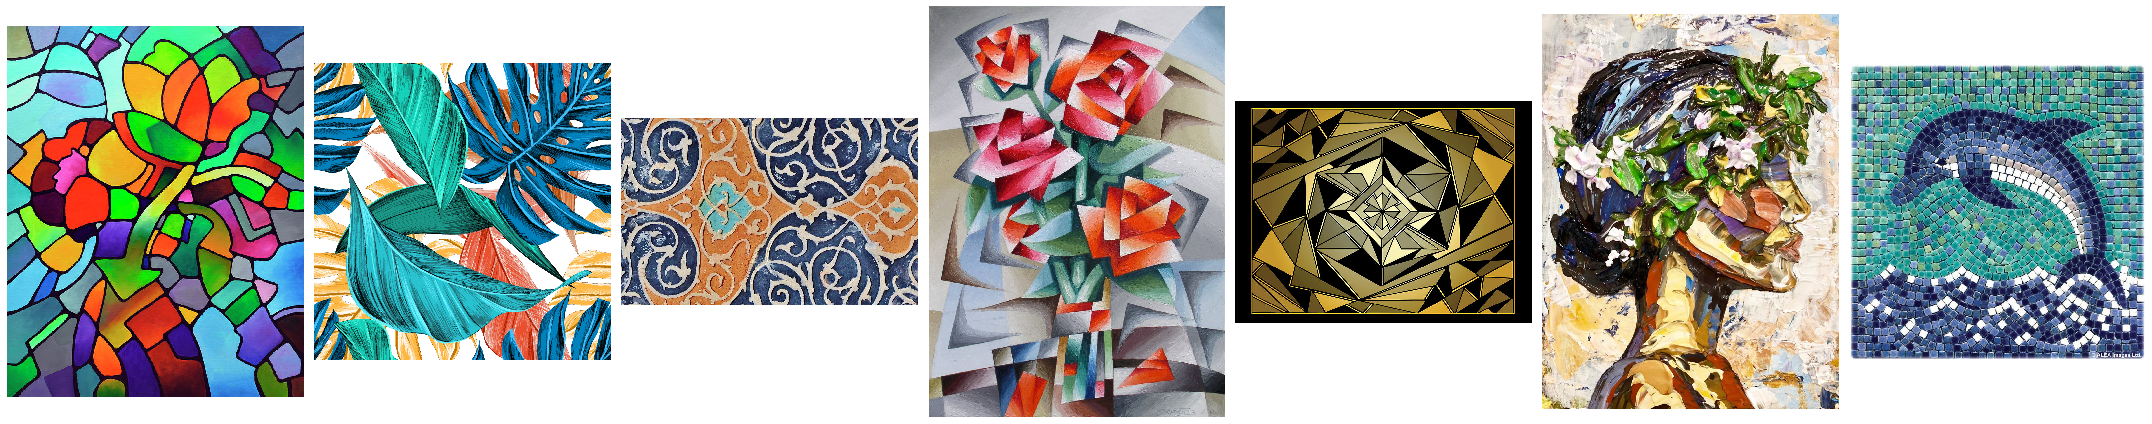

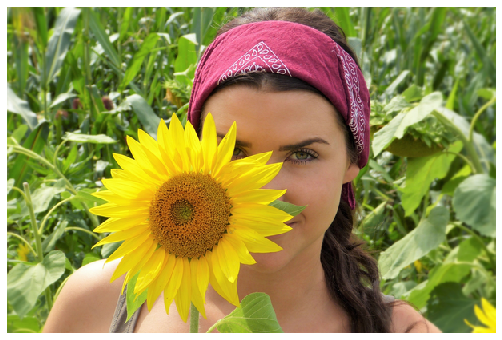

In [17]:
DEMO_STYLE_NUMS = [0, 1, 2, 3, 4, 5, 6]
files = [natsorted(os.listdir(args.style_images_dir))[style_num] for style_num in DEMO_STYLE_NUMS]
fig, axes = plt.subplots(1, len(DEMO_STYLE_NUMS))
fig.set_size_inches(30, 6)
for num, file in enumerate(files):
    img = Image.open(args.style_images_dir+file)
    axes[num].imshow(img)
    axes[num].axis('off');
tight_layout()
plot_img(sample_content_img, (30, 6))

# Train

In [ ]:
train(args) 

In [ ]:
print(f"FINISHED TRAINING {datetime.now().strftime('%x %X')}")

# Test

In [ ]:
model_path = "Models/my_approach_model/checkpoint_images_43000/"
init_transformer_model = model_path + 'transformer.model' #'Models/Save/my_model_orig.pth'
init_style_models_dir = model_path #'/store/Datasets/Sample_Styles/'  # path to style-images directory (holding images of styles)

transformer = TransformerNet(6, DEVICE)
transformer.load_transformer(init_transformer_model)
transformer.load_styles(init_style_models_dir)
transformer.to(DEVICE)

In [ ]:
transformer.style_names

In [ ]:
max_content_pixels_count = 496**2

for content_img_name in [f'content{i}.jpg' for i in range(1, 20)]:
    for style_name in transformer.style_names:
        img = transformer.stylize(Image.open('../../Images/Contents/'+content_img_name), style_name, max_content_pixels_count)
        img.save(f'../../Images/Output/My approach/{content_img_name[:-4]}_{style_name}.jpg')

### Train GuidedPatternTransformation (new name of Pattern Bank Transformation)

In [18]:
class Arguments:
    pass

args=Arguments()
args.models_dir = 'Models/'
args.model_name = 'my_approach_model_PBT'   # trained model saved to args.save_model_dir+args.model_name+'.pth'. Also args.model_name affects name of checkpoint models. 
args.exp_weight = 0.01  # how much to exponentially average content and style loss time series
args.dataset = '../../Datasets/MS_COCO/val_2017/' # take from https://cocodataset.org/#download. 
args.style_images_dir = '../../Images/Patterns/'  # path to style-images directory (holding images of styles)
args.init_transformer_model = init_transformer_model #Models/current4/checkpoint_images_100000/transformer.model 
args.init_style_models_dir = init_style_models_dir #'/store/Datasets/Sample_Styles/'  # path to style-images directory (holding images of styles)
args.batch_size = 1    # take more, if GPU memory permits
args.epochs = 20       # number of training epochs (training over 20.000 images is enough for convergence)
args.style_size = 352  # size of style-image, default is the original size of style image
args.content_size = 496  # size of training images, default is 256 X 256
args.seed = 42         # random seed for training
args.lr = 3e-4         # learning rate for optimizer
args.content_weight = 1e1   
args.log_interval = 100    # number of batches after which the training loss is logged
args.checkpoint_interval = 250   # set to None for no checkpoints. number of batches after which a checkpoint of the trained model will be created
args.style_div = 3  # by how much to divide H and W to reproduce larger style patches

In [27]:
def centered_gram_matrix(y):
    (b, ch, h, w) = y.size()
    features = y.view(b, ch, w * h)
    
    f_mean = features.mean(-1).unsqueeze(-1)
    #f_std = features.std(-1).unsqueeze(-1)
    
    features = (features - f_mean)#/(f_std+1e-6)
    features_t = features.transpose(1, 2) # swapped ch and w*h, transpose share storage with original
    gram = features.bmm(features_t) / (ch * h * w)
    return gram

def train_PBT(args):

    save_dir = args.models_dir+args.model_name+'/'
    shutil.rmtree(save_dir, ignore_errors=True)    
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    
    
    content2tensor_train = transforms.Compose([
        transforms.Resize(args.content_size), # the shorter side is resize to match image_size
        transforms.RandomCrop(args.content_size), 
        transforms.ToTensor(), # to tensor [0,1]
        transforms.Lambda(lambda x: x.to(DEVICE))
    ])    
    
    style2tesor_train = transforms.Compose([
        transforms.Resize(args.style_size),
        transforms.CenterCrop(args.style_size),
        transforms.ToTensor(),  # to tensor [0,1]
        transforms.Lambda(lambda x: x.to(DEVICE))
    ])
    
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)

    train_dataset = datasets.ImageFolder(args.dataset, content2tensor_train)
    train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True) # to provide a batch loader

    pattern_filenames = os.listdir(args.style_images_dir)  # style_name=name of style file without extension
    pattern_names= [filename2stylename(filename) for filename in pattern_filenames]  # style name from filename: XXXX.jpg, XXXX.png XXXX-23.jpg XXXX-0.jpg => XXXX
    patterns_count = len(pattern_names)
    print(f'Patterns count: {patterns_count}')
    
    
    fig = figure(figsize=[30,20])
    gs = fig.add_gridspec(3, 3)
    main_ax = fig.add_subplot(gs[0, :])
    axes=[]
    for i in range(2):
        for j in range(3):
            axes.append(fig.add_subplot(gs[1+i, j]))
    tight_layout()

    transformer = TransformerNet(6, DEVICE)
    
    if args.init_transformer_model:
        transformer.load_transformer(args.init_transformer_model)
    
    if args.init_style_models_dir:
        transformer.load_styles(args.init_style_models_dir)
    else:
        transformer.add_styles(style_names)    
    
    transformer.train_all()
    
    transformer.to(DEVICE)
    optimizer = Adam(transformer.parameters(), args.lr)
    mse_loss = torch.nn.MSELoss()

    vgg = Vgg16(requires_grad=False).to(DEVICE)

    patterns_batch = []

    for i in range(patterns_count):
        pattern = ensure_rgb(Image.open(args.style_images_dir + pattern_filenames[i]))    #load_image(args.style_images_dir + style_filenames[i], size=args.style_size)
        pattern = style2tesor_train(pattern)
        patterns_batch.append(pattern)

    patterns = torch.stack(patterns_batch) 

    patterns = normalize_batch(patterns)
    features_patterns = vgg(patterns)

    gram_pattern = [centered_gram_matrix(y) for y in features_patterns]
    
    smoothed_content_loss = None
    smoothed_pattern_loss = None

    smoothed_content_losses = []
    smoothed_pattern_losses = []
    smoothed_total_losses = []
    global_img_counts = []
    global_img_count = 0
    global_batch_num = 0
    
    set_PBT_mode(transformer, mode='lock')
    
    style_names = transformer.style_names
    styles_count = len(style_names)

    for epoch in range(1,args.epochs+1):
        transformer.train()
        img_count = 0
        for (x, _) in train_loader:
            n_batch = len(x)

            if n_batch < args.batch_size:
                break # skip to next epoch when no enough images left in the last batch of current epoch

            img_count += n_batch
            global_img_count += n_batch
            global_batch_num+=1
            
            optimizer.zero_grad() # initialize with zero gradients

            batch_style_ids = list(np.random.randint(0, styles_count, size=n_batch))
            batch_style_names = [style_names[i] for i in batch_style_ids]
            
            pattern_id = global_batch_num % patterns_count
            batch_pattern_ids = [pattern_id]*n_batch
            
            y = transformer(x, style_names = batch_style_names, pattern_num = pattern_id)   # rem: x.to(DEVICE)
            
            x = normalize_batch(x)
            y = normalize_batch(y)

            features_y = vgg(y)   # rem: x.to(DEVICE)   features_y = vgg(y)
            features_x = vgg(x)   # rem: x.to(DEVICE)   features_x = vgg(x)
            content_loss = args.content_weight * mse_loss(features_y.relu2_2, features_x.relu2_2)
            pattern_loss = torch.cuda.FloatTensor([0])
            
            with torch.no_grad():
                model_loss = [content_loss.cpu().item()/args.content_weight]

            for ft_y, gm_s in zip(features_y[-3:], gram_pattern[-3:]):
                gm_y = centered_gram_matrix(ft_y)
                with torch.no_grad():
                    model_loss.append(mse_loss(gm_y, gm_s[batch_pattern_ids]).cpu().item())
                pattern_loss += mse_loss(gm_y, gm_s[batch_pattern_ids, :, :])

            pattern_loss *= args.style_weights[pattern_id]
            
            total_loss = content_loss + pattern_loss
            total_loss.backward()
            optimizer.step()

            
            if smoothed_content_loss==None:
                 smoothed_content_loss = content_loss.item()
            else:
                smoothed_content_loss = args.exp_weight*content_loss.item()+(1-args.exp_weight)*smoothed_content_loss
            
            if smoothed_pattern_loss==None:
                 smoothed_pattern_loss = pattern_loss.item()
            else:
                smoothed_pattern_loss = args.exp_weight*pattern_loss.item()+(1-args.exp_weight)*smoothed_pattern_loss

            smoothed_total_loss = smoothed_content_loss+smoothed_pattern_loss


            if global_batch_num % args.log_interval == args.log_interval-1:
                message = f"{datetime.now().strftime('%x %X')}  epoch {epoch}  [{img_count:>5d}/{len(train_dataset)}]  Content:{smoothed_content_loss:.2f}  Style:{smoothed_pattern_loss:.2f}  Total:{smoothed_total_loss:.2f}"

                smoothed_content_losses.append(smoothed_content_loss)
                smoothed_pattern_losses.append(smoothed_pattern_loss)
                smoothed_total_losses.append(smoothed_total_loss)
                global_img_counts.append(global_img_count)

                main_ax.clear()
                for i in range(6):
                    axes[i].clear()

                main_ax.set_title(message)
                start = len(global_img_counts)-150
                main_ax.plot(global_img_counts[start:], smoothed_content_losses[start:], color='r', label='content')
                main_ax.plot(global_img_counts[start:], smoothed_pattern_losses[start:], color='g', label='pattern')
                main_ax.plot(global_img_counts[start:], smoothed_total_losses[start:], color='b', label='total')
                main_ax.legend(loc='upper right')
                main_ax.grid()


                with torch.no_grad():
                    result_images = []
                    for pattern_num in range(patterns_count):
                        #cur_style = 
                        result = transformer(sample_content, style_names = batch_style_names, pattern_num=pattern_num)
                        result_images.append( postprocess_image(result) )
                    for num, result_img in enumerate(result_images):
                        axes[num].imshow(result_img)
                        axes[num].axis('off');
                    display.display(fig)
                    display.clear_output(wait=True)                      

            if (args.checkpoint_interval!=None) and (global_batch_num % 50) == 0:
                np.save(save_dir+f'model_loss_{global_img_count}.npy', np.array(model_loss))

            if (args.checkpoint_interval!=None) and (global_batch_num % args.checkpoint_interval) == 0:
                transformer.eval().cpu()
                checkpoint_save_dir = save_dir+f'checkpoint_images_{global_img_count}/'
                Path(checkpoint_save_dir).mkdir(parents=True, exist_ok=True)
                transformer.save_transformer(checkpoint_save_dir+'transformer.model')
                transformer.save_styles(checkpoint_save_dir)
                transformer.to(DEVICE).train()

    # save model
    transformer.eval().cpu()
    transformer.save_transformer(save_dir+'transformer.model')
    transformer.save_styles(save_dir)

In [ ]:
args.style_weights = [4e5, 4e5, 2e5, 7e5, 1e6, 2e5]  
train_PBT(args)

In [ ]:
model_path = "Models/my_approach_model_PBT/checkpoint_images_2500/"
init_transformer_model = model_path + 'transformer.model' #'Models/Save/my_model_orig.pth'
init_style_models_dir = model_path #'/store/Datasets/Sample_Styles/'  # path to style-images directory (holding images of styles)

transformer = TransformerNet(6, DEVICE)
transformer.load_transformer(init_transformer_model)
transformer.load_styles(init_style_models_dir)
transformer.to(DEVICE)

In [ ]:
max_content_pixels_count = 496**2

for content_img_name in [f'content{i}.jpg' for i in range(1, 20)]:
    print("Curr content is:", content_img_name)
    for style_name in transformer.style_names:
        for pattern_num in range(6):
            for alpha in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
                img = transformer.stylize(Image.open('../../Images/Contents/'+content_img_name), style_name, max_content_pixels_count, pattern_num=pattern_num, alpha=alpha)
                img.save(f'../../Images/Output/My approach PTB 1500/{content_img_name[:-4]}__{style_name}_p={pattern_num}_a={alpha}.jpg')